In [146]:
# bibliotecas
import numpy as np
import scipy as sp
from numpy import pi, sin, cos, exp, sqrt, tan
import pylab as plt
import scipy.constants as cte
from scipy.constants import hbar, epsilon_0
from scipy.interpolate import interp1d
from scipy.integrate import quad, nquad
import timeit

In [147]:
# constantes do problema

deltaEc = 1.25*cte.e # altura do poco do eletron
deltaEv = 1.45*cte.e # altura do poco do buraco
me = cte.m_e*.15 # massa efetiva do eletron
mh = cte.m_e*0.14 # massa efetiva do buraco
cte_dielet = 4.96 # cte dieletrica
camadas = 14 # numero de camadas. varia entre 12 e 18 camadas (7 e 11 nm)
a = camadas*.59e-9 # tamanho do nanocubo

In [148]:
# definicao de algumas variaveis que serao utilizadas no codigo

global lamb, V0, m, E

mi = 1/(1/me + 1/mh) # mu_perp
eps = cte_dielet*epsilon_0 # permissividade do material

### 1. Calcular o valor de $k$ do poço finito

O valor do $k$ é calculado pela equação transcendental

$$
    \tan{(ka/2)} = \kappa/k \qquad\Rightarrow\qquad \tan{(ka/2)} - \kappa/k = 0.
$$

O que será feito então é definir uma função a partir da última equação cuja sua variável é $E$ e encontrar a sua primeira raíz.

In [149]:
k = lambda E: sqrt(2*m*E)/hbar
kappa = lambda E: sqrt(2*m*(V0 - E))/hbar
f_transc = lambda E: tan(k(E)*a/2) - kappa(E)/k(E) # funcao transcendental do poco finito


"""
funcao que devolve a primeira raiz de uma funcao dado um range x do seu domínio
e um range y da sua imagem.

percorre x até encontrar dois pontos seguidos nos quais y muda de sinal, então chama a funcao
secante para encontrar a raíz entre esses pontos
"""
def raiz(x, y):
    for i in range(1, len(y)):
        if y[i]*y[i-1] < 0:
            raiz = secante(x[i-1], x[i])
            out = raiz
            break
    return out

"""
funcao que devolve a raiz de f_transc entre dois pontos E1 e E2

o calculo é feito utilizando o método da secante e a precisão do valor encontrado
é dada por epsilon
"""
def secante(E1, E2):
    global E
    E = E2
    epsilon = 1e-9
    while abs(f_transc(E2)) > epsilon:
        E1, E2 = E2, E2 - f_transc(E2)*(E2 - E1)/(f_transc(E2) - f_transc(E1))
        E = E2
    return E2

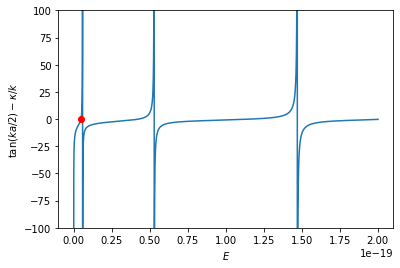

In [150]:
# valores para o eletron
V0 = deltaEc
m = me

eps_E = cte.e*1e-5 # epsilon da energia para evitar divergência da função f_transc em 0
Es = np.linspace(eps_E, deltaEc, 10000) # range na energia no qual será procurada a raíz
y = [f_transc(Ei) for Ei in Es]

# valor da energia de ligacao do elétron
Ee = raiz(Es, y)

k_e = k(Ee) # k do elétron
kappa_e = kappa(Ee) # kappa do elétron

# grafico para verificação visual da raíz encontrada
plt.plot(Es, y)
plt.plot(raiz(Es, y), 0, 'ro')
plt.ylim(-100, 100)
plt.ylabel(r'$\tan{(ka/2)} - \kappa/k$')
plt.xlabel(r'$E$')
plt.show()

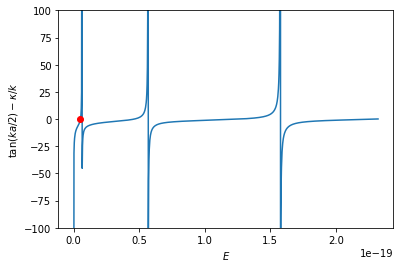

In [151]:
# valores para o buraco
V0 = deltaEv
m = mh

Es = np.linspace(eps_E, deltaEv, 1000) # range na energia no qual será procurada a raíz
y = [f_transc(Ei) for Ei in Es]

# valor da energia de ligacao do buraco
Eh = raiz(Es, y)

k_h = k(Eh) # k do buraco
kappa_h = kappa(Eh) # kappa do buraco

# grafico para verificação visual da raíz encontrada
plt.plot(Es, y)
plt.plot(raiz(Es, y), 0, 'ro')
plt.ylim(-100, 100)
plt.ylabel(r'$\tan{(ka/2)} - \kappa/k$')
plt.xlabel(r'$E$')
plt.show()

### 2. Cálculo das funções $\psi_e$ e $\psi_h$

A partir dos valores de $k$ encontrados para o elétron e para o buraco definimos uma função para a função de onda não normalizada de cada partícula pela equação 

\begin{equation}
    \psi(x)=
	\begin{cases}
	\cos(ka/2)\exp(\kappa a/2)\exp(\kappa x), &  x \leq -a/2\\
	\cos(kx), &  |x| \leq a/2\\
	\cos(ka/2)\exp(\kappa a/2)\exp(-\kappa x), &  x \geq a/2\\
	\end{cases}
\end{equation}

Isolando o $x$ no último caso obtemos

$$
    x = \frac{1}{\kappa}\ln\left[\frac{\cos(ka/2)e^{\kappa a/2}}{\psi(x)}\right]
$$

assim, dado um valor de $\psi(x)$ conseguimos encontrar o valor de $x$ em que isso ocorre. Para limitar o espaço em um tamanho infinito consideramos que $x$ é infinito quando $\psi(x) \sim 10^{-3}$.

In [152]:
# tamanho do infinito para a variavel a e 'dobro do infinito' para x
L = 2/kappa_e*np.log(cos(k_e*a/2)*exp(kappa_e*a/2)*1e3)

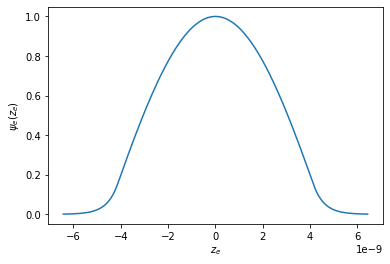

In [153]:
# funcao de onda do elétron em função da distância x
def psie(x):
    if x < -a/2:
        return cos(k_e*a/2)*exp(kappa_e*a/2)*exp(kappa_e*x)
    elif x < a/2:
        return cos(k_e*x)
    else:
        return cos(k_e*a/2)*exp(kappa_e*a/2)*exp(-kappa_e*x)

# gráfico para visualização da função de onda
xs = np.linspace(-L/2, L/2, 1000)
plt.plot(xs, [psie(xi) for xi in xs])
plt.ylabel(r'$\psi_e(z_e)$')
plt.xlabel(r'$z_e$')
plt.show()

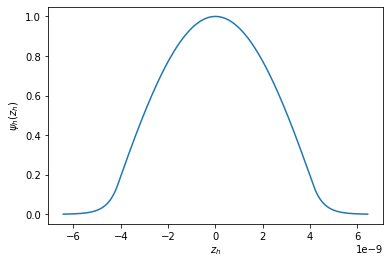

In [154]:
# funcao de onda do buraco em função da distância x
def psih(x):
    if x < -a/2:
        return cos(k_h*a/2)*exp(kappa_h*a/2)*exp(kappa_h*x)
    elif x < a/2:
        return cos(k_h*x)
    else:
        return cos(k_h*a/2)*exp(kappa_h*a/2)*exp(-kappa_h*x)

# gráfico para visualização da função de onda
plt.plot(xs, [psih(xi) for xi in xs])
plt.ylabel(r'$\psi_h(z_h)$')
plt.xlabel(r'$z_h$')
plt.show()

### 3. Definição da função $p(a)$

A função $p(a)$ é a seguinte integral
$$
    p(a) = \int^{L/2-a}_{-L/2} \psi_e^2(z+a)\psi_h^2(z) + \psi_e^2(z)\psi_h^2(z+a) dz,
$$
onde $a\in[0, \infty]$. Será feito uma interpolação para $p(a)$ pois assim seu valor em um ponto é calculado mais rapidamente, visto que não tem que passar pelos if.

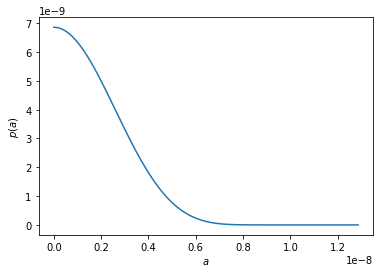

In [155]:
# p(a)
p_inte = lambda z, a: (psie(z+a)*psih(z))**2 + (psie(z)*psih(z+a))**2
p = lambda a: quad(p_inte, -L/2, L/2-a, args=(a))[0]

# interpolação da funcao p(a)
arange = np.linspace(0, L, 200)
prange = [p(i) for i in arange]
p = interp1d(arange, prange)

# gráfico para visualização da função p(a)
arange = np.linspace(0, L, 200)
plt.plot(arange, [p(ai) for ai in arange])
plt.ylabel(r'$p(a)$')
plt.xlabel(r'$a$')
plt.show()

### 4. Cálculo dos termos do hamiltoniano

Os termos finais a serem calculados são 

\begin{equation}
    \mathcal{D} = \int_0^L\int_0^L\int_0^L p(x)p(y)p(z)\psi_r^2(x, y, z)\,dx\,dy\,dz
\end{equation}

\begin{equation}
    \mathcal{A} =
    E_e\mathcal{D} 
    + \frac{\hbar^2}{2m^*_e}\frac{\mathcal{D}}{\lambda^2}
\end{equation}

\begin{equation}
    \mathcal{B} =
    E_h\mathcal{D} 
    + \frac{\hbar^2}{2m^*_h}\frac{\mathcal{D}}{\lambda^2}
\end{equation}

\begin{equation}
    \mathcal{C} = \frac{-e^2}{4\pi\epsilon}
    \int_0^L\int_0^L\int_0^L p(x)p(y)p(z)
    \frac{\psi_r^2}{r}
    \,dx\,dy\,dz
\end{equation}

In [160]:
"""
função que devolve o valor de psi^2 no ponto (x, y, z)
"""
def psir2(x, y, z):
    global lamb
    r = sqrt(x**2 + y**2 + z**2)
    return exp(-2*r/lamb)

"""
função que devolve o valor de psi^2/r no ponto (x, y, z)
"""
def psir2r(x, y, z):
    global lamb
    r = sqrt(x**2 + y**2 + z**2)
    return exp(-2*r/lamb)/r

"""
função que retorna o valor da energia calculada para os valor de lamb atual
"""
def E():
    
    # calcula os valores de D, A, B e C
    D_inte = lambda x, y, z: p(x)*p(y)*p(z)*psir2(x, y, z)
    D = nquad(D_inte, [[0, L], [0, L], [0, L]])[0]
    A = (3*Ee + hbar**2/2/me/lamb**2)*D
    B = (3*Eh + hbar**2/2/mh/lamb**2)*D
    C_inte = lambda x, y, z: p(x)*p(y)*p(z)*psir2r(x, y, z)
    C = -cte.e**2/4/pi/eps*nquad(C_inte, [[0, L], [0, L], [0, L]])[0]
    
    return (A + B + C)/D

"""
função que gera o gráfico com o valor da energia de ligação

é feita uma iteração em um range de lamb calculando a energia para cada ponto
"""
def final():
    
    ti = timeit.default_timer() # tempo inicial
    
    global lamb
    
    lambini = 4.5 # valor inicial de lamb
    lambfin = 6.5 # valor final de lamb
    n_lamb = 100 # número de pontos para em lamb
    lamb_range = np.linspace(lambini*1e-9, lambfin*1e-9, n_lamb) # range em lamb
    
    Es = [] # lista com os valores de E para cada lamb
    
    for lambi in lamb_range:
        lamb = lambi
#         print('lamb:', lamb) # print opcional para mostrar qual valor de lamb esta sendo calculado
        Eb = E() - 3*Ee - 3*Eh # Eb = E - 3Ee - 3Eh
        Es.append(Eb)
        
    # acha o minimo e seus parametros
    energia = np.amin(Es)/cte.e*1e3 # Eb em meV
    lamb = lamb_range[np.where(Es == np.amin(Es))[0][0]]/1e-9 # lamb em nm
    
    # grafico de E em função de lamb
    nome = 'nanocubo_' + str(camadas) + '_camadas' + str(n_lamb) + 'pontos.svg' # nome da figura final
    plt.plot(lamb_range*1e9, np.array(Es)/1e-3/cte.e)
    plt.xlabel(r'$\lambda$' + ' (nm)')
    plt.ylabel(r'$E$' + ' (meV)')
    plt.title(r'$E_B = $' + str(round(energia, 2)) + ' meV, ' + r'$\lambda = $' +\
              str(round(lamb, 2)) + ' nm')
    plt.plot(lamb, energia, 'r.')
    plt.tight_layout()
    plt.savefig(nome)
    plt.show()
    
    tf = timeit.default_timer() # tempo final
    print('Tempo de execucao:', round((tf - ti)/60, 3), 'minutos')

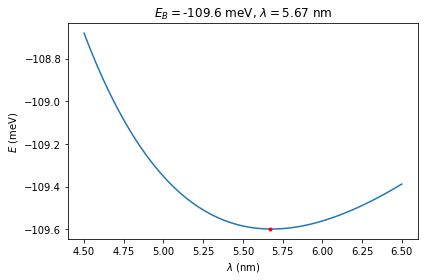

Tempo de execucao: 4.486 minutos


In [161]:
final()